In [193]:
# Common Imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data Import Module
%run ./Module_DataImport.ipynb

# Data Visualization Module
%run ./Module_DataVisualization.ipynb

# Data Derivatives Module
%run ./Module_DataDerivatives.ipynb

## Deployment Information
In the code cell are variables that can be tuned based on the deployment, they are described in more detail below:
- student_list: a integer list of the students included in this study. Valid student numbers are between 2 and 9, inclusive.
- start_date: the first date that you would like to include in the summary. The earliest date that can be chosen that will ensure at least one student has data is 03/11/2019.
- end_date: the last date to include in the summary. No more data are available after 04/15/2019.

The start and end dates are defaulted to the earliest and latest dates, respectively, given in the description above. 

In [184]:
student_list = np.arange(2,10,1)
start_date = '04/01/2019'
end_date = '04/04/2019'
# Getting the number of hours
time_diff = datetime.strptime(end_date, '%m/%d/%Y') - datetime.strptime(start_date, '%m/%d/%Y')
num_hours = int(divmod(time_diff.total_seconds(),3600)[0])+24 # add 24 because we import all of the last day

## Data Import

### Indoor Environmental Quality Data
In the code cell below, the indoor environmental quality data is imported from the ```beacon_data``` directory available for Students 2 through 9. The variables include:
1. Temperature
2. Relative Humidity$^1$
3. PM2.5

The functions for importing the data are stored in the ```Module_DataImport.pynb``` notebook in the same directory as this master notebook. 

$^1$Temperature and Relative Humidity are imported together and stored in the same dataframe. Collectively, they are referred to as "thermal comfort"

In [185]:
TC_byStudent = pd.Series()
Concentration_byStudent = pd.Series()
for n in student_list:
    print()
    print('Importing IEQ Data for: Student',n)
    print('\nImporting Thermal Comfort Data...')
    TC_temp = ieqImport(str(n),'sht31d',['time','rh','temp'],'all',start_date,end_date)
    if len(TC_temp) < 5*num_hours: # We should get at least 5 data points per hour
        print('\tInsufficient Data - not importing')
    else:
        TC_byStudent['Student' + str(n)] = TC_temp
        print('\tImport Complete')
        
    print('\nImporting PM2.5 Concentration Data...')
    Concentration_temp = ieqImport(str(n),'pms5003',['time','PM2.5'],[0,2],start_date,end_date)
    if len(Concentration_temp) < 5*num_hours: # We should get at least 5 data points per hour
        print('\tInsufficient Data - not importing')
    else:
        Concentration_byStudent['Student' + str(n)] = Concentration_temp
        print('\tImport Complete')


Importing IEQ Data for: Student 2

Importing Thermal Comfort Data...
	Number of datapoints: 2926
	Import Complete

Importing PM2.5 Concentration Data...
	Number of datapoints: 27
	Insufficient Data - not importing

Importing IEQ Data for: Student 3

Importing Thermal Comfort Data...
	Number of datapoints: 9050
	Import Complete

Importing PM2.5 Concentration Data...
	Number of datapoints: 253
	Insufficient Data - not importing

Importing IEQ Data for: Student 4

Importing Thermal Comfort Data...
	Number of datapoints: 17072
	Import Complete

Importing PM2.5 Concentration Data...
	Number of datapoints: 111
	Insufficient Data - not importing

Importing IEQ Data for: Student 5

Importing Thermal Comfort Data...
	Number of datapoints: 9233
	Import Complete

Importing PM2.5 Concentration Data...
	Number of datapoints: 103
	Insufficient Data - not importing

Importing IEQ Data for: Student 6

Importing Thermal Comfort Data...
	Number of datapoints: 16555
	Import Complete

Importing PM2.5 Con

### Sleep Quality Data
There are two types of sleep quality data, gathered from different sources:
1. Sleep Stages from Fitbit
2. Perceived Sleep Quality from Beiwe EMA Surveys

Both datasets are imported below in the code cell.

In [194]:
SS_byInd = pd.Series()
PSQ_byInd = pd.Series()
for n in student_list:
    print('Importing Sleep Quality Data for: Student',n)
    SS_byInd['Student' + str(n)] = fitbitImport(str(n),'S' + str(n) + '_SleepStages.csv',['Time','ShortWakes','Stage_Label'],[1,3,4],start_date,end_date)

Importing Sleep Quality Data for: Student 2
16428
	Number of datapoints: 631
Importing Sleep Quality Data for: Student 3
7736
	Number of datapoints: 730
Importing Sleep Quality Data for: Student 4
16999
	Number of datapoints: 3986
Importing Sleep Quality Data for: Student 5
	No data from this deployment range
Importing Sleep Quality Data for: Student 6
	No data from this deployment range
Importing Sleep Quality Data for: Student 7
	No data from this deployment range
Importing Sleep Quality Data for: Student 8
17777
	Number of datapoints: 3992
Importing Sleep Quality Data for: Student 9
	No data from this deployment range


## Single Variable Data Visualization
Below are visualizations that incorporate one variable.

### PM2.5
There are three main PM2.5 Concentration figures:
1. Time Series showing daily PM2.5 concentrations in their home
2. Time Series showing daily AQI for PM2.5 in their home
3. Bar Chart showing daily median concentrations in their home

#### PM2.5 Concentration Profile

In [187]:
# Data Visualization Module
%run ./Module_DataVisualization.ipynb

# Looping through all the imported data
for name in Concentration_byStudent.index:
    ## Created new columns in the dataframe that store the month and date
    Concentration_byStudent[name]['Month'] = Concentration_byStudent[name].index.month        
    Concentration_byStudent[name]['Day'] = Concentration_byStudent[name].index.day
    ## Splitting the dataframe by the month and day to get a dataframe per day
    agg = Concentration_byStudent[name].groupby(['Month','Day'])
    Median_byInd = agg.median()
    
    ## Looping through the individual's days of data and plotting
    index = 0
    for group in agg:
        ### Converting the group into a dataframe
        group = pd.DataFrame(data=group[1])
        ### Plotting Concentration profile
        #getFinePMTimeSeries(group.index,group['PM2.5'],'Concentration ($\mu$g/m$^3$)',index+1)
        ### Plotting AQI profile
        #getFinePMTimeSeries(group.index,getAQI(group['PM2.5']),'Air Quality Index',index+1)
        index += 1

### Sleep Stages/Quality

Student2
Student3
Student4
Student8


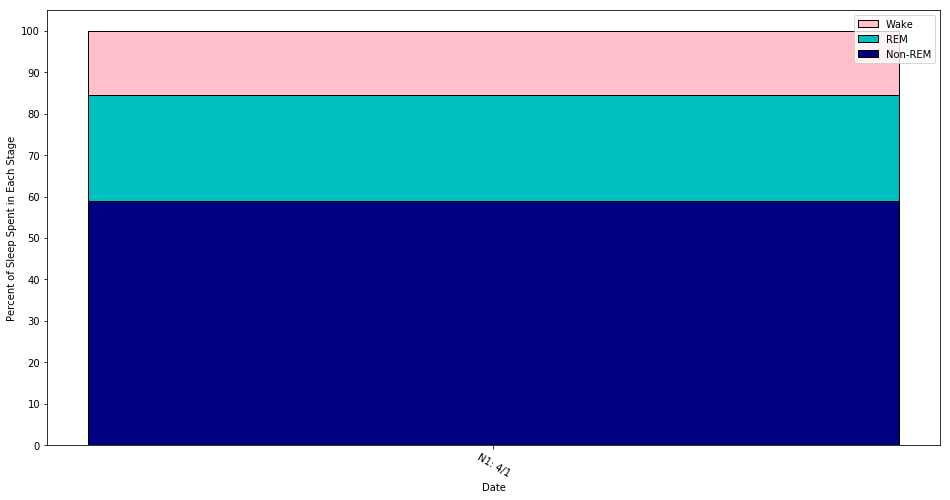

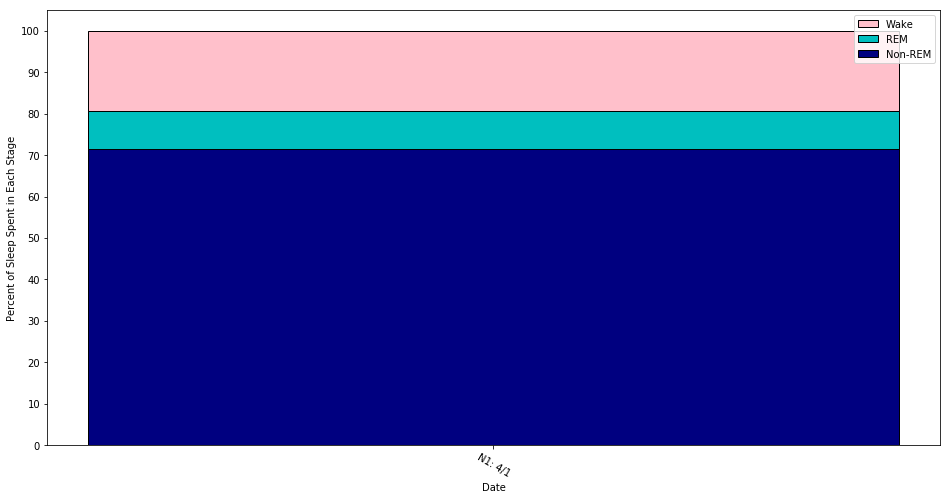

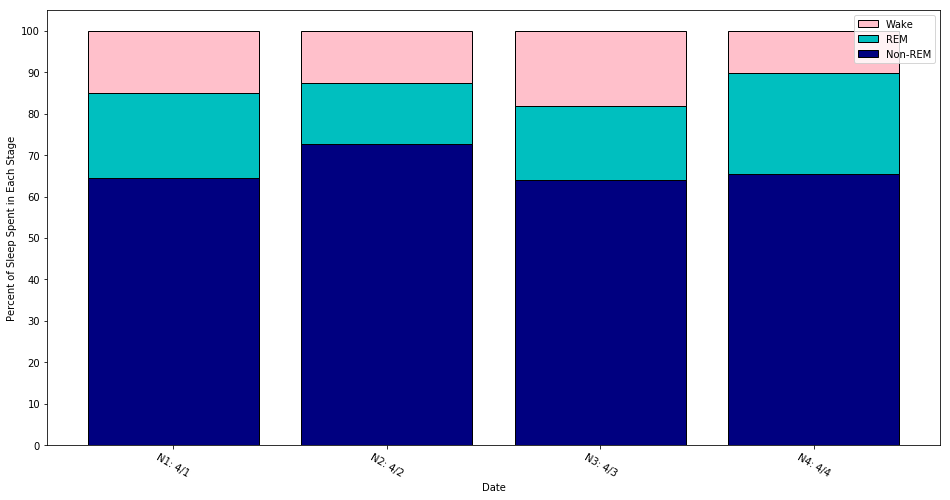

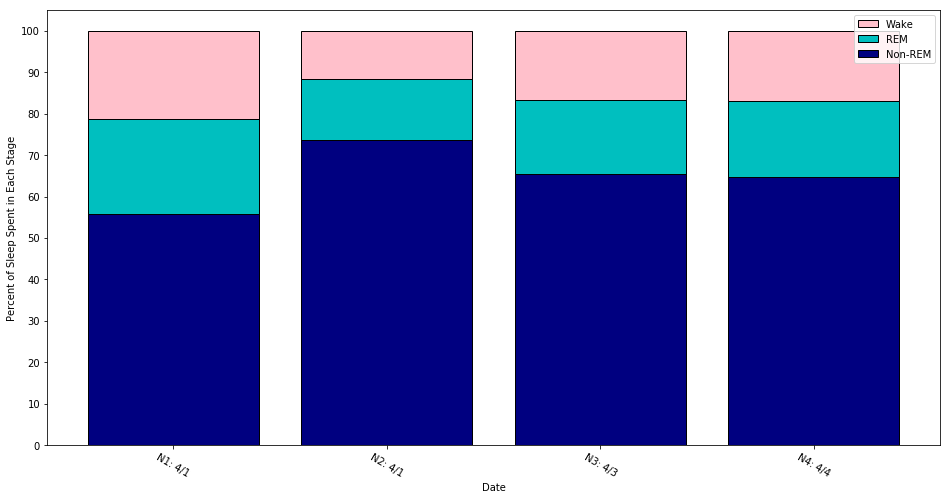

In [195]:
# Data Derivatives Module
%run ./Module_DataDerivatives.ipynb

# Data Visualization Module
%run ./Module_DataVisualization.ipynb

#print(SS_byInd[0])
SE_byInd = pd.Series()
for name in SS_byInd.index:
    if len(SS_byInd[name]) > 0:
        print(name)
        SE_byInd[name] = getSleepEfficiency(SS_byInd[name])
        getSleepStagePercentages(SE_byInd[name])
        #print(SE_byInd[name].head())

In [189]:


# Re-formatting Sleep Stages dataframe
stages = SS_byInd[name]['Stage_Label']
times = SS_byInd[name].index
locs = []
for i in range(len(SS_byInd[name])-1):
    # Parsing out the days by looking for timesteps greater than 5 minutes
    if SS_byInd[name].index[i+1]-SS_byInd[name].index[i] > timedelta(seconds = 300):
        locs.append(i+1)

stages_byDay = np.split(stages,locs)
times_byDay = np.split(times,locs)
#times_byID[name] = times_byDay

#print(stages_byDay[1])

KeyError: 'Stage_Label'

In [ ]:
    temp = pd.Series()
    fig, ax1 = plt.subplots(figsize=(10,6))
    # Counting the number of 30-second values for each sleep stage
    for j in range(len(stages_byDay)):
        wake = 0
        light = 0
        rem = 0
        deep = 0
        for k in range(len(stages_byDay[j])):
            if stages_byDay[j][k] == 3:
                wake += 1
            elif stages_byDay[j][k] == 2:
                rem += 1
            elif stages_byDay[j][k] == 1:
                light += 1
            else:
                deep += 1

        # Converting the count measurement to number of hours
        rest = (((wake + rem + light + deep) * 30 ) / 60 ) /60
        wake_hr = (wake * 30) / 60 / 60
        rem_hr = (rem * 30) / 60 / 60
        light_hr = (light * 30) /60 / 60
        deep_hr = (deep * 30) / 60 / 60

        # Sleep Stages - Stacked Bar Chart
        # Using an if-block to make sure the legend doesn't repeat for each day
        if j == len(stages_byDay)-1:
            p5 = ax1.bar('N' + str(j+1) + ': ' + str(times_byDay[j][0])[5:7]+'/'+str(times_byDay[j][0])[8:10],wake_hr, bottom=deep_hr+light_hr+rem_hr, color='pink',edgecolor='k',label='Wake')
            p6 = ax1.bar('N' + str(j+1) + ': ' + str(times_byDay[j][0])[5:7]+'/'+str(times_byDay[j][0])[8:10],rem_hr,bottom=deep_hr+light_hr,color='c',edgecolor='k',label='REM')
            p7 = ax1.bar('N' + str(j+1) + ': ' + str(times_byDay[j][0])[5:7]+'/'+str(times_byDay[j][0])[8:10],light_hr,bottom=deep_hr,color='b',edgecolor='k',label='Light')
            p8 = ax1.bar('N' + str(j+1) + ': ' + str(times_byDay[j][0])[5:7]+'/'+str(times_byDay[j][0])[8:10],deep_hr,color='navy',edgecolor='k',label='Deep')
        else:
            p5 = ax1.bar('N' + str(j+1) + ': ' + str(times_byDay[j][0])[5:7]+'/'+str(times_byDay[j][0])[8:10], wake_hr, bottom=deep_hr+light_hr+rem_hr, color='pink',edgecolor='k')
            p6 = ax1.bar('N' + str(j+1) + ': ' + str(times_byDay[j][0])[5:7]+'/'+str(times_byDay[j][0])[8:10],rem_hr,bottom=deep_hr+light_hr,color='c',edgecolor='k')
            p7 = ax1.bar('N' + str(j+1) + ': ' + str(times_byDay[j][0])[5:7]+'/'+str(times_byDay[j][0])[8:10],light_hr,bottom=deep_hr,color='b',edgecolor='k')
            p8 = ax1.bar('N' + str(j+1) + ': ' + str(times_byDay[j][0])[5:7]+'/'+str(times_byDay[j][0])[8:10],deep_hr,color='navy',edgecolor='k')

        # Formatting x-axis
        ax1.set_xlabel('Date')
        ax1.xaxis.set_tick_params(rotation=-30)

        # Formatting y-axis
        ax1.set_yticks([0,2,4,6,8,10,12])
        ax1.set_ylabel('Number of Hours Spent at Sleep Stage')
        plt.legend((p5[0],p6[0],p7[0],p8[0]), ('Wake','REM','Light','Deep'))